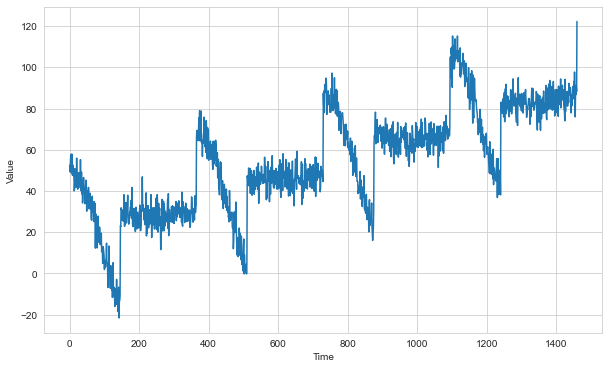

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras


def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40



series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise




plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [2]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [3]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [5]:
train_set = sequential_window_dataset(X_train,window_size)

In [10]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, None, 100)            40800     
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense_1 (Dense)              (1, None, 1)              101       
_________________________________________________________________
lambda_1 (Lambda)            (1, None, 1)              0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [18]:
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8*10**(epoch/20))

In [19]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [20]:
reset_states = ResetStatesCallback()

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [22]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 7s 21ms/step - loss: 90.9249 - mae: 91.4249
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 83.8908 - mae: 84.3908
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 75.4839 - mae: 75.9839
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 66.0604 - mae: 66.5604
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 55.5063 - mae: 56.0063
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 43.7518 - mae: 44.2516
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 30.7851 - mae: 31.2843
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 17.1337 - mae: 17.6294
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 10.0235 - mae: 10.5102
Epoch 10/100
33/33 [==============================] - 0s 8ms/step - loss: 10.0564 - mae: 10.5480
Epoch 11/100
33/33 [=================

33/33 [==============================] - 0s 9ms/step - loss: 25.8322 - mae: 26.3279
Epoch 87/100
33/33 [==============================] - 0s 9ms/step - loss: 21.3123 - mae: 21.8053
Epoch 88/100
33/33 [==============================] - 0s 9ms/step - loss: 27.4543 - mae: 27.9517
Epoch 89/100
33/33 [==============================] - 0s 9ms/step - loss: 34.6138 - mae: 35.1108
Epoch 90/100
33/33 [==============================] - 0s 10ms/step - loss: 38.7581 - mae: 39.2561
Epoch 91/100
33/33 [==============================] - 0s 9ms/step - loss: 41.7196 - mae: 42.2156
Epoch 92/100
33/33 [==============================] - 0s 8ms/step - loss: 30.2788 - mae: 30.7742
Epoch 93/100
33/33 [==============================] - 0s 9ms/step - loss: 34.4542 - mae: 34.9532
Epoch 94/100
33/33 [==============================] - 0s 8ms/step - loss: 32.1896 - mae: 32.6881
Epoch 95/100
33/33 [==============================] - 0s 9ms/step - loss: 42.5465 - mae: 43.0446
Epoch 96/100
33/33 [======================

(1e-08, 0.0001, 0.0, 30.0)

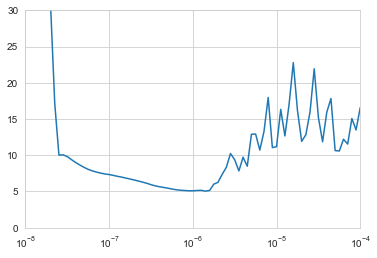

In [23]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [24]:
# Second

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [26]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [27]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [28]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [29]:
reset_states = ResetStatesCallback()

In [30]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [31]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [32]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,callbacks=[early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 2s 26ms/step - loss: 49.5591 - mae: 50.0567 - val_loss: 16.1126 - val_mae: 16.6071
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 18.1358 - mae: 18.6279 - val_loss: 11.8442 - val_mae: 12.3388
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 24.9572 - mae: 25.4548 - val_loss: 22.3804 - val_mae: 22.8800
Epoch 4/500
33/33 [==============================] - 0s 11ms/step - loss: 12.3162 - mae: 12.8085 - val_loss: 14.1753 - val_mae: 14.6696
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 10.3071 - mae: 10.7958 - val_loss: 8.5434 - val_mae: 9.0322
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 8.3790 - mae: 8.8684 - val_loss: 7.4126 - val_mae: 7.8940
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 8.0845 - mae: 8.5717 - val_loss: 7.2894 - val_mae: 7.7771
Epoch 8/500
33/33 [==============================] - 0s 11

33/33 [==============================] - 0s 11ms/step - loss: 5.9185 - mae: 6.4018 - val_loss: 6.6410 - val_mae: 7.1260
Epoch 63/500
33/33 [==============================] - 0s 11ms/step - loss: 5.4394 - mae: 5.9152 - val_loss: 5.3438 - val_mae: 5.8274
Epoch 64/500
33/33 [==============================] - 0s 11ms/step - loss: 6.0768 - mae: 6.5616 - val_loss: 7.0836 - val_mae: 7.5705
Epoch 65/500
33/33 [==============================] - 0s 11ms/step - loss: 5.4077 - mae: 5.8859 - val_loss: 5.3543 - val_mae: 5.8402
Epoch 66/500
33/33 [==============================] - 0s 11ms/step - loss: 5.6973 - mae: 6.1794 - val_loss: 5.8871 - val_mae: 6.3690
Epoch 67/500
33/33 [==============================] - 0s 11ms/step - loss: 5.4535 - mae: 5.9300 - val_loss: 5.1638 - val_mae: 5.6402
Epoch 68/500
33/33 [==============================] - 0s 11ms/step - loss: 6.1330 - mae: 6.6194 - val_loss: 6.6775 - val_mae: 7.1626
Epoch 69/500
33/33 [==============================] - 0s 11ms/step - loss: 5.4270 

33/33 [==============================] - 0s 12ms/step - loss: 5.6278 - mae: 6.1088 - val_loss: 6.3396 - val_mae: 6.8203
Epoch 124/500
33/33 [==============================] - 0s 11ms/step - loss: 5.5779 - mae: 6.0622 - val_loss: 5.4632 - val_mae: 5.9375
Epoch 125/500
33/33 [==============================] - 0s 11ms/step - loss: 5.7779 - mae: 6.2630 - val_loss: 5.9952 - val_mae: 6.4800
Epoch 126/500
33/33 [==============================] - 0s 11ms/step - loss: 5.5703 - mae: 6.0550 - val_loss: 5.4749 - val_mae: 5.9503
Epoch 127/500
33/33 [==============================] - 0s 10ms/step - loss: 5.5956 - mae: 6.0775 - val_loss: 6.2700 - val_mae: 6.7505
Epoch 128/500
33/33 [==============================] - 0s 10ms/step - loss: 5.3497 - mae: 5.8291 - val_loss: 5.5373 - val_mae: 6.0198
Epoch 129/500
33/33 [==============================] - 0s 10ms/step - loss: 5.4576 - mae: 5.9373 - val_loss: 6.5215 - val_mae: 7.0043
Epoch 130/500
33/33 [==============================] - 0s 11ms/step - loss: 

In [33]:
model = keras.models.load_model("my_checkpoint.h5")

In [34]:
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])

In [35]:
rnn_forecast = rnn_forecast[0,split_time-1:-1,0]

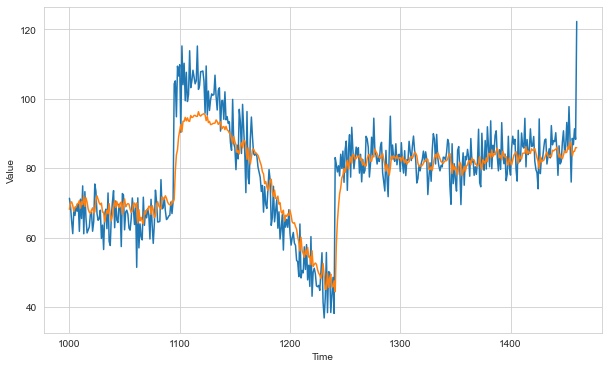

In [36]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

# Forecasting With CNN

In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)


train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [38]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [39]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [40]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [41]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 8s 80ms/step - loss: 87.8127 - mae: 88.3121
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 87.1046 - mae: 87.6041
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 85.9298 - mae: 86.4292
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 84.3817 - mae: 84.8809
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 82.4802 - mae: 82.9795
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 80.2357 - mae: 80.7350
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 77.7306 - mae: 78.2300
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 75.1118 - mae: 75.6112
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 72.4477 - mae: 72.9472
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 69.8895 - mae: 70.3891
Epoch 11/100
8/8 [==============================] - 0s 7

8/8 [==============================] - 0s 9ms/step - loss: 17.1748 - mae: 17.6711
Epoch 89/100
8/8 [==============================] - 0s 8ms/step - loss: 14.0306 - mae: 14.5239
Epoch 90/100
8/8 [==============================] - 0s 6ms/step - loss: 13.5610 - mae: 14.0537
Epoch 91/100
8/8 [==============================] - 0s 10ms/step - loss: 12.5595 - mae: 13.0521
Epoch 92/100
8/8 [==============================] - 0s 7ms/step - loss: 14.1124 - mae: 14.6062
Epoch 93/100
8/8 [==============================] - 0s 6ms/step - loss: 14.4844 - mae: 14.9786
Epoch 94/100
8/8 [==============================] - 0s 9ms/step - loss: 12.0768 - mae: 12.5689
Epoch 95/100
8/8 [==============================] - 0s 10ms/step - loss: 20.6798 - mae: 21.1753
Epoch 96/100
8/8 [==============================] - 0s 9ms/step - loss: 18.6219 - mae: 19.1166
Epoch 97/100
8/8 [==============================] - 0s 7ms/step - loss: 17.6277 - mae: 18.1207
Epoch 98/100
8/8 [==============================] - 0s 7ms/st

(1e-08, 0.0001, 0.0, 30.0)

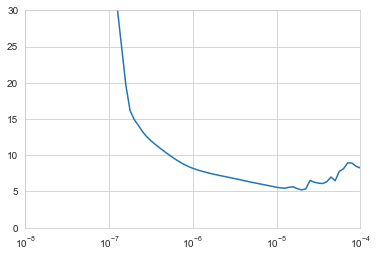

In [42]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [43]:
# SEcond

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [45]:
window_size = 30

In [46]:

train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [48]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,
             metrics=['mae'])

In [49]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [50]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set,epochs=500,validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 98ms/step - loss: 56.8920 - mae: 57.3911 - val_loss: 28.7551 - val_mae: 29.2522
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 26.1535 - mae: 26.6492 - val_loss: 38.9398 - val_mae: 39.4379
Epoch 3/500
8/8 [==============================] - 0s 20ms/step - loss: 17.3737 - mae: 17.8692 - val_loss: 30.0563 - val_mae: 30.5549
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 12.0031 - mae: 12.4929 - val_loss: 24.5223 - val_mae: 25.0199
Epoch 5/500
8/8 [==============================] - 0s 19ms/step - loss: 9.9147 - mae: 10.4025 - val_loss: 18.8237 - val_mae: 19.3202
Epoch 6/500
8/8 [==============================] - 0s 21ms/step - loss: 8.8326 - mae: 9.3188 - val_loss: 15.8701 - val_mae: 16.3646
Epoch 7/500
8/8 [==============================] - 0s 22ms/step - loss: 8.0764 - mae: 8.5621 - val_loss: 12.5365 - val_mae: 13.0260
Epoch 8/500
8/8 [==============================] - 0s 19ms/step - l

8/8 [==============================] - 0s 20ms/step - loss: 4.5195 - mae: 4.9954 - val_loss: 6.3221 - val_mae: 6.8059
Epoch 64/500
8/8 [==============================] - 0s 19ms/step - loss: 4.5169 - mae: 4.9931 - val_loss: 6.6566 - val_mae: 7.1401
Epoch 65/500
8/8 [==============================] - 0s 19ms/step - loss: 4.5520 - mae: 5.0291 - val_loss: 5.9712 - val_mae: 6.4533
Epoch 66/500
8/8 [==============================] - 0s 22ms/step - loss: 4.5655 - mae: 5.0427 - val_loss: 6.2118 - val_mae: 6.6945
Epoch 67/500
8/8 [==============================] - 0s 22ms/step - loss: 4.5186 - mae: 4.9957 - val_loss: 6.5178 - val_mae: 7.0019
Epoch 68/500
8/8 [==============================] - 0s 22ms/step - loss: 4.5125 - mae: 4.9891 - val_loss: 6.0936 - val_mae: 6.5759
Epoch 69/500
8/8 [==============================] - 0s 23ms/step - loss: 4.4900 - mae: 4.9666 - val_loss: 6.2442 - val_mae: 6.7279
Epoch 70/500
8/8 [==============================] - 0s 20ms/step - loss: 4.4817 - mae: 4.9574 - 

8/8 [==============================] - 0s 21ms/step - loss: 4.2966 - mae: 4.7711 - val_loss: 5.7007 - val_mae: 6.1829
Epoch 126/500
8/8 [==============================] - 0s 21ms/step - loss: 4.2949 - mae: 4.7693 - val_loss: 5.6814 - val_mae: 6.1633
Epoch 127/500
8/8 [==============================] - 0s 20ms/step - loss: 4.2914 - mae: 4.7662 - val_loss: 5.7845 - val_mae: 6.2672
Epoch 128/500
8/8 [==============================] - 0s 19ms/step - loss: 4.2914 - mae: 4.7661 - val_loss: 5.5579 - val_mae: 6.0381
Epoch 129/500
8/8 [==============================] - 0s 20ms/step - loss: 4.2868 - mae: 4.7610 - val_loss: 5.6332 - val_mae: 6.1150
Epoch 130/500
8/8 [==============================] - 0s 21ms/step - loss: 4.2897 - mae: 4.7635 - val_loss: 5.6779 - val_mae: 6.1600
Epoch 131/500
8/8 [==============================] - 0s 20ms/step - loss: 4.2899 - mae: 4.7643 - val_loss: 5.6155 - val_mae: 6.0973
Epoch 132/500
8/8 [==============================] - 0s 20ms/step - loss: 4.2839 - mae: 4.

8/8 [==============================] - 0s 21ms/step - loss: 4.1787 - mae: 4.6517 - val_loss: 5.5364 - val_mae: 6.0180
Epoch 188/500
8/8 [==============================] - 0s 20ms/step - loss: 4.1769 - mae: 4.6502 - val_loss: 5.3091 - val_mae: 5.7885
Epoch 189/500
8/8 [==============================] - 0s 21ms/step - loss: 4.1812 - mae: 4.6548 - val_loss: 5.3929 - val_mae: 5.8730
Epoch 190/500
8/8 [==============================] - 0s 20ms/step - loss: 4.1844 - mae: 4.6577 - val_loss: 5.3439 - val_mae: 5.8238
Epoch 191/500
8/8 [==============================] - 0s 19ms/step - loss: 4.1827 - mae: 4.6569 - val_loss: 5.5929 - val_mae: 6.0749
Epoch 192/500
8/8 [==============================] - 0s 21ms/step - loss: 4.1765 - mae: 4.6502 - val_loss: 5.4910 - val_mae: 5.9726
Epoch 193/500
8/8 [==============================] - 0s 19ms/step - loss: 4.1784 - mae: 4.6515 - val_loss: 5.6719 - val_mae: 6.1537
Epoch 194/500
8/8 [==============================] - 0s 21ms/step - loss: 4.1732 - mae: 4.

8/8 [==============================] - 0s 19ms/step - loss: 4.1173 - mae: 4.5889 - val_loss: 5.2305 - val_mae: 5.7104
Epoch 250/500
8/8 [==============================] - 0s 21ms/step - loss: 4.1203 - mae: 4.5930 - val_loss: 5.3335 - val_mae: 5.8141
Epoch 251/500
8/8 [==============================] - 0s 21ms/step - loss: 4.1148 - mae: 4.5869 - val_loss: 5.2506 - val_mae: 5.7302
Epoch 252/500
8/8 [==============================] - 0s 19ms/step - loss: 4.1152 - mae: 4.5875 - val_loss: 5.1660 - val_mae: 5.6452
Epoch 253/500
8/8 [==============================] - 0s 19ms/step - loss: 4.1140 - mae: 4.5858 - val_loss: 5.1410 - val_mae: 5.6195
Epoch 254/500
8/8 [==============================] - 0s 21ms/step - loss: 4.1198 - mae: 4.5925 - val_loss: 5.1606 - val_mae: 5.6389
Epoch 255/500
8/8 [==============================] - 0s 20ms/step - loss: 4.1137 - mae: 4.5857 - val_loss: 5.3092 - val_mae: 5.7901
Epoch 256/500
8/8 [==============================] - 0s 19ms/step - loss: 4.1079 - mae: 4.

8/8 [==============================] - 0s 20ms/step - loss: 4.0827 - mae: 4.5542 - val_loss: 5.3865 - val_mae: 5.8673
Epoch 312/500
8/8 [==============================] - 0s 21ms/step - loss: 4.0956 - mae: 4.5673 - val_loss: 5.0651 - val_mae: 5.5442
Epoch 313/500
8/8 [==============================] - 0s 20ms/step - loss: 4.1084 - mae: 4.5810 - val_loss: 5.0601 - val_mae: 5.5375
Epoch 314/500
8/8 [==============================] - 0s 20ms/step - loss: 4.0985 - mae: 4.5707 - val_loss: 5.0864 - val_mae: 5.5649
Epoch 315/500
8/8 [==============================] - 0s 19ms/step - loss: 4.0785 - mae: 4.5499 - val_loss: 5.3229 - val_mae: 5.8038
Epoch 316/500
8/8 [==============================] - 0s 20ms/step - loss: 4.0785 - mae: 4.5500 - val_loss: 5.3331 - val_mae: 5.8142
Epoch 317/500
8/8 [==============================] - 0s 19ms/step - loss: 4.0887 - mae: 4.5613 - val_loss: 5.2591 - val_mae: 5.7396
Epoch 318/500
8/8 [==============================] - 0s 21ms/step - loss: 4.0683 - mae: 4.

In [51]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [52]:
model = keras.models.load_model("my_checkpoint.h5")

In [53]:
rnn_forecast = model_forcast(model,series[:,np.newaxis],window_size)

In [54]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

In [55]:
rnn_forecast

array([ 63.522083,  66.740295,  67.35496 ,  66.72056 ,  66.1737  ,
        67.63561 ,  67.782036,  68.16942 ,  67.41239 ,  67.49337 ,
        67.15662 ,  67.50221 ,  68.57186 ,  68.697624,  67.41359 ,
        68.635086,  67.84589 ,  66.94863 ,  65.35784 ,  66.2473  ,
        66.180954,  66.70535 ,  65.75537 ,  65.36793 ,  66.80574 ,
        68.09459 ,  67.11525 ,  66.317764,  68.39271 ,  68.92113 ,
        67.384636,  66.36115 ,  65.33852 ,  65.87333 ,  65.08541 ,
        65.22967 ,  64.342575,  64.33847 ,  63.252113,  64.068855,
        65.64706 ,  65.863945,  64.46619 ,  66.06732 ,  66.73468 ,
        67.54405 ,  67.279434,  68.729095,  66.91253 ,  66.670235,
        68.28991 ,  67.82327 ,  66.00185 ,  67.207115,  68.16447 ,
        67.302826,  67.13912 ,  67.347374,  67.50168 ,  67.89304 ,
        66.583115,  67.34821 ,  64.87382 ,  64.28405 ,  64.19905 ,
        63.34969 ,  61.132084,  62.663902,  62.44476 ,  63.533653,
        63.082783,  63.007904,  65.26786 ,  65.770935,  65.767

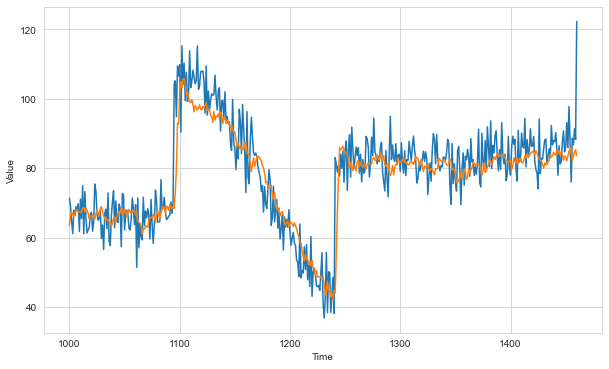

In [56]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

# Fully Convolutional Forcasting

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [58]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [60]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

In [62]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))

In [63]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [64]:
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [65]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 51ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 36.6836 - mae: 37.1822
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 33.3644 - mae: 33.8628
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 27.9449 - mae: 28.4427
Epoch 11/100
8/8 [==============================] - 0s 6ms

8/8 [==============================] - 0s 8ms/step - loss: 35.5638 - mae: 36.0619
Epoch 89/100
8/8 [==============================] - 0s 6ms/step - loss: 77.5147 - mae: 78.0102
Epoch 90/100
8/8 [==============================] - 0s 7ms/step - loss: 19.9881 - mae: 20.4836
Epoch 91/100
8/8 [==============================] - 0s 6ms/step - loss: 17.0355 - mae: 17.5293
Epoch 92/100
8/8 [==============================] - 0s 6ms/step - loss: 16.2334 - mae: 16.7275
Epoch 93/100
8/8 [==============================] - 0s 6ms/step - loss: 16.3663 - mae: 16.8604
Epoch 94/100
8/8 [==============================] - 0s 6ms/step - loss: 16.3756 - mae: 16.8696
Epoch 95/100
8/8 [==============================] - 0s 7ms/step - loss: 16.1038 - mae: 16.5978
Epoch 96/100
8/8 [==============================] - 0s 9ms/step - loss: 15.9420 - mae: 16.4365
Epoch 97/100
8/8 [==============================] - 0s 7ms/step - loss: 15.9507 - mae: 16.4445
Epoch 98/100
8/8 [==============================] - 0s 7ms/step

(0.0001, 0.1, 0.0, 30.0)

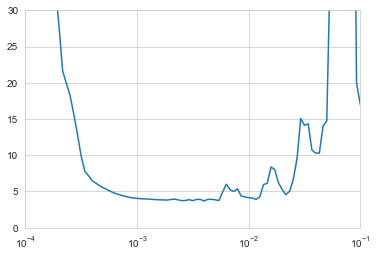

In [66]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [67]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [68]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [69]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [71]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)

In [72]:
model.compile(loss=keras.callbacks.EarlyStopping(patience=50))
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)
history = model.fit(train_set,epochs=500,validation_data=valid_set,
                   callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 83ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9777 - val_mae: 68.4777
Epoch 3/500
8/8 [==============================] - 0s 13ms/step - loss: 35.1357 - mae: 35.6344 - val_loss: 60.8664 - val_mae: 61.3664
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 30.8280 - mae: 31.3262 - val_loss: 50.2194 - val_mae: 50.7190
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 24.9595 - mae: 25.4564 - val_loss: 36.6519 - val_mae: 37.1479
Epoch 6/500
8/8 [==============================] - 0s 15ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5157
Epoch 7/500
8/8 [==============================] - 0s 15ms/step - loss: 18.8909 - mae: 19.3858 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 0s 14ms/ste

8/8 [==============================] - 0s 17ms/step - loss: 3.7903 - mae: 4.2602 - val_loss: 4.2385 - val_mae: 4.7130
Epoch 64/500
8/8 [==============================] - 0s 17ms/step - loss: 3.7843 - mae: 4.2542 - val_loss: 4.2392 - val_mae: 4.7140
Epoch 65/500
8/8 [==============================] - 0s 17ms/step - loss: 3.7788 - mae: 4.2488 - val_loss: 4.2542 - val_mae: 4.7294
Epoch 66/500
8/8 [==============================] - 0s 18ms/step - loss: 3.7734 - mae: 4.2431 - val_loss: 4.3072 - val_mae: 4.7845
Epoch 67/500
8/8 [==============================] - 0s 16ms/step - loss: 3.7748 - mae: 4.2445 - val_loss: 4.2547 - val_mae: 4.7297
Epoch 68/500
8/8 [==============================] - 0s 17ms/step - loss: 3.7626 - mae: 4.2321 - val_loss: 4.2141 - val_mae: 4.6882
Epoch 69/500
8/8 [==============================] - 0s 19ms/step - loss: 3.7542 - mae: 4.2234 - val_loss: 4.3000 - val_mae: 4.7770
Epoch 70/500
8/8 [==============================] - 0s 16ms/step - loss: 3.7521 - mae: 4.2215 - 

8/8 [==============================] - 0s 16ms/step - loss: 3.4958 - mae: 3.9580 - val_loss: 4.1994 - val_mae: 4.6752
Epoch 126/500
8/8 [==============================] - 0s 16ms/step - loss: 3.4961 - mae: 3.9585 - val_loss: 4.2044 - val_mae: 4.6809
Epoch 127/500
8/8 [==============================] - 0s 17ms/step - loss: 3.4919 - mae: 3.9539 - val_loss: 4.2794 - val_mae: 4.7559
Epoch 128/500
8/8 [==============================] - 0s 17ms/step - loss: 3.4889 - mae: 3.9501 - val_loss: 4.2138 - val_mae: 4.6898
Epoch 129/500
8/8 [==============================] - 0s 17ms/step - loss: 3.4832 - mae: 3.9441 - val_loss: 4.1876 - val_mae: 4.6628
Epoch 130/500
8/8 [==============================] - 0s 16ms/step - loss: 3.4820 - mae: 3.9428 - val_loss: 4.2469 - val_mae: 4.7232
Epoch 131/500
8/8 [==============================] - 0s 15ms/step - loss: 3.4779 - mae: 3.9384 - val_loss: 4.2608 - val_mae: 4.7369
Epoch 132/500
8/8 [==============================] - 0s 16ms/step - loss: 3.4742 - mae: 3.

In [73]:
cnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

In [74]:
cnn_forecast = cnn_forecast[split_time-window_size:-1,-1,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series()